In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# from elo import Elo

In [3]:
df = pd.read_csv('data/EPL_season_22_23.csv')
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0,2,A,0,1,...,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85
1,E0,06/08/2022,12:30,Fulham,Liverpool,2,2,D,1,0,...,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2,0,H,1,0,...,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00
3,E0,06/08/2022,15:00,Leeds,Wolves,2,1,H,1,1,...,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86


In [4]:
# Selecting useful columns
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR']]
df.head()

,Date,HomeTeam,AwayTeam,FTR
0,05/08/2022,Crystal Palace,Arsenal,A
1,06/08/2022,Fulham,Liverpool,D
2,06/08/2022,Bournemouth,Aston Villa,H
3,06/08/2022,Leeds,Wolves,H
4,06/08/2022,Newcastle,Nott'm Forest,H


In [5]:
df.shape

(380, 4)

## Basic Pre-processing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      380 non-null    object
 1   HomeTeam  380 non-null    object
 2   AwayTeam  380 non-null    object
 3   FTR       380 non-null    object
dtypes: object(4)
memory usage: 12.0+ KB


In [7]:
df.describe()

,Date,HomeTeam,AwayTeam,FTR
count,380,380,380,380
unique,117,20,20,3
top,28/05/2023,Crystal Palace,Arsenal,H
freq,10,19,19,184


In [8]:
# Checking for null values
df.isnull().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTR         0
dtype: int64

In [9]:
# Checking for duplicates
df.duplicated().sum()

0

In [10]:
# Label Encoding
# Using 1 = Win, 0.5 = Draw, 0 = Loss for Elo ranking
df['Result'] = df['FTR'].apply(lambda x: 1 if x == 'H' else (0.5 if x == 'D' else 0))

In [11]:
df.head()

,Date,HomeTeam,AwayTeam,FTR,Result
0,05/08/2022,Crystal Palace,Arsenal,A,0.0
1,06/08/2022,Fulham,Liverpool,D,0.5
2,06/08/2022,Bournemouth,Aston Villa,H,1.0
3,06/08/2022,Leeds,Wolves,H,1.0
4,06/08/2022,Newcastle,Nott'm Forest,H,1.0


## Minimal EDA

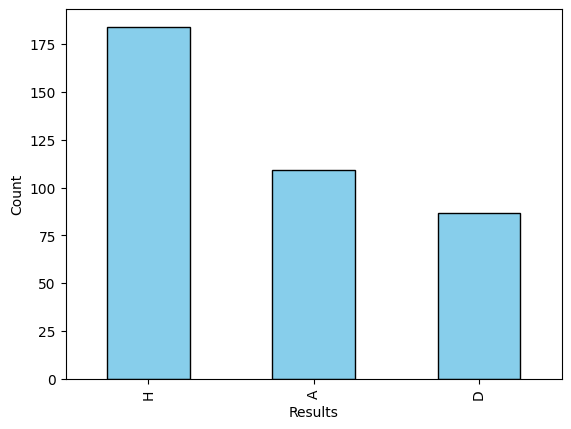

In [12]:
# Unique value counts
df['FTR'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Results')
plt.ylabel('Count')
plt.show()

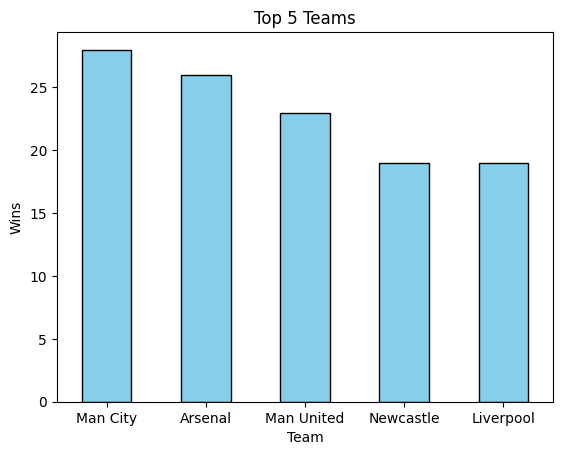

In [13]:
# Top 5 teams
total_wins = pd.concat([df['HomeTeam'][df['FTR'] == 'H'], df['AwayTeam'][df['FTR'] == 'A']]).value_counts()
top_5_teams = total_wins.head(5)

top_5_teams.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Team')
plt.ylabel('Wins')
plt.title('Top 5 Teams')
plt.xticks(rotation=0)

plt.show()

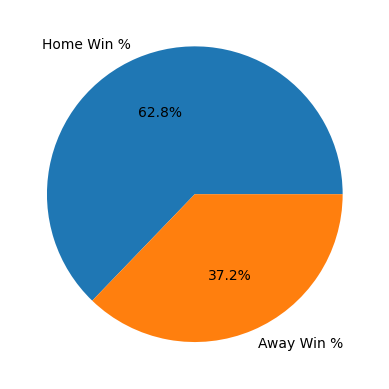

In [14]:
# Win % at home and away games
total_wins_at_home = (df['HomeTeam'][df['FTR'] == 'H']).value_counts()
total_wins_at_away = (df['AwayTeam'][df['FTR'] == 'A']).value_counts()
total_games = len(df)

win_perecentage_at_home = (total_wins_at_home.sum() / total_games) * 100
win_perecentage_at_away = (total_wins_at_away.sum() / total_games) * 100

plt.pie([win_perecentage_at_home, win_perecentage_at_away], labels=['Home Win %', 'Away Win %'], autopct='%1.1f%%')
plt.show()

## Calculating Elo Scores

In [15]:
# Creating a function to calculate and update Elos
def calculate_elo(r1, r2, result, K=32):
    e_r1 = 1 / (1 + 10 ** ((r2 - r1) / 400))
    e_r2 = 1 / (1 + 10 ** ((r1 - r2) / 400))

    elo_p1 = r1 + K * (result - e_r1)
    elo_p2 = r2 + K * (result - e_r2)

    return elo_p1, elo_p2

In [16]:
elo_scores = {} # Dictionary to store and update elo scores
base_elo_score = 1500 # Initializing the base elo score to 1500
teams = set(df['HomeTeam']).union(set(df['AwayTeam']))
elo_history = {team: [] for team in teams} # Initializing a dictionary of lists containing elo scores for each team
elo_dates = [] # Initializing a list to store match dates

In [17]:
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    result = row['Result']

    r1 = elo_scores.get(home_team, base_elo_score)
    r2 = elo_scores.get(away_team, base_elo_score)

    new_elo_p1, new_elo_p2 = calculate_elo(r1, r2, result, K=40)

    elo_scores[home_team] = new_elo_p1
    elo_scores[away_team] = new_elo_p2

    elo_dates.append(row['Date'])

    for team in teams:
        elo_history[team].append(elo_scores.get(team, base_elo_score))

In [18]:
# Storing the elo scores in a separate dataframe
elo_df = pd.DataFrame({'Date': elo_dates})
for team in teams:
    elo_df[team] = elo_history[team]

## Visualizing Results

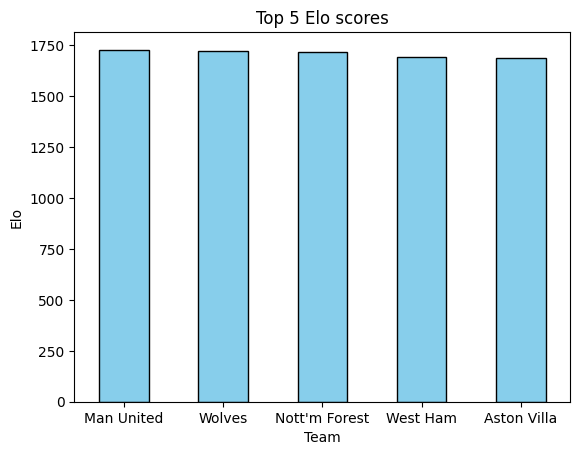

In [19]:
# Top 5 elo scores
total_elo = elo_df.iloc[-1, 1:].sort_values(ascending=False)
top_5_elo = total_elo.head()
top_5_elo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 5 Elo scores')
plt.ylabel('Elo')
plt.xlabel('Team')
plt.xticks(rotation=None)
plt.show()

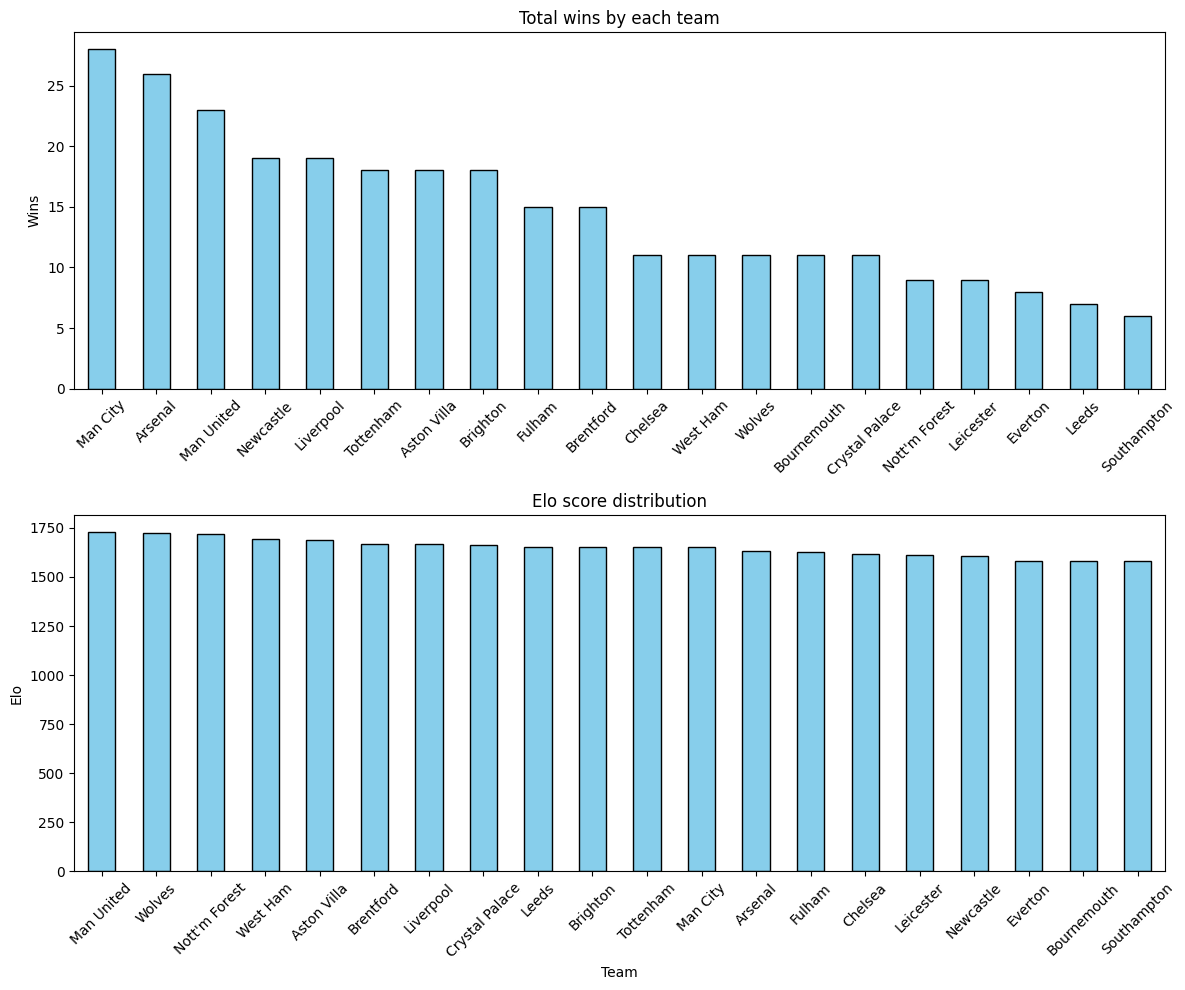

In [20]:
# Comparing the distribution of wins with the elo scores
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
total_wins.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Wins')
plt.title('Total wins by each team')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
total_elo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Elo')
plt.title('Elo score distribution')
plt.xticks(rotation=45)

plt.xlabel('Team')
plt.tight_layout()
plt.show()

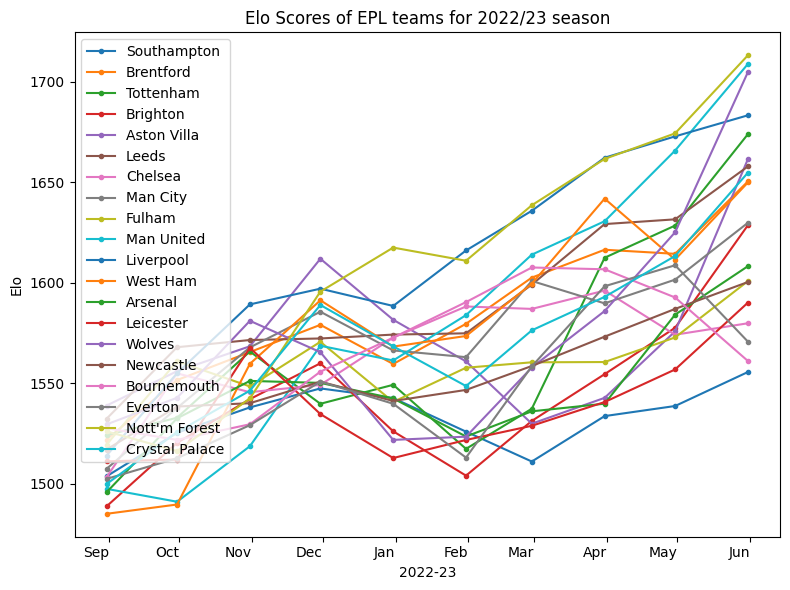

In [23]:
# Plotting the trend of elo scores for each team grouped by month
elo_df['Date'] = pd.to_datetime(elo_df['Date'], format='%d/%m/%Y')

plt.figure(figsize=(8, 6))

for team in teams:
    monthly_elo = elo_df[['Date', team]].set_index('Date').resample('M').mean()
    plt.plot(monthly_elo.index, monthly_elo[team], label=team, linestyle='solid', marker='.')

plt.gcf().autofmt_xdate()
date_format = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('Elo Scores of EPL teams for 2022/23 season')
plt.xlabel('2022-23')
plt.ylabel('Elo')
plt.xticks(rotation=None)
plt.legend()
plt.tight_layout()
plt.show()